# DSC-609: Machine Learning

## Michael Albers
### 8/25/2022

## Overview

Use Natural Language Processing (NLP) to classify online Data Science job postings

- [Data Gathering](#Data-Gathering)
    - [Python Code](#Python-Code)
    - [Filter Job posting files](#Filter-Job-posting-files)
- [Preprocessing](#Preprocessing)
    - [Part of Speech Tagging](#Part-of-Speech-Tagging)
    - [Create Label Column](#Create-Label-Column)
- [Job Postings Data Set](#Job-Postings-Data-Set)
    - [Encode labels](#Encode-labels)
    - [Split dataframe into Training and Test sets](#Split-dataframe-into-Training-and-Test-sets)
    - [Word tokenization](#Word-tokenization)
- [Naive Bayes Classifier](#Naive-Bayes-Classifier)
    - [Training Naive Bayes Classifier](#Training-Naive-Bayes-Classifier)
    - [Testing Naive Bayes Classifier](#Testing-Naive-Bayes-Classifier)
    - [Classification Metrics](#Classification-Metrics)
- [Random Forest Classifier](#Random-Forest-Classifier)
    - [Training Random Forest Classifier](#Training-Random-Forest-Classifier)
    - [Testing Random Forest Classifier](#Testing-Random-Forest-Classifier)
    - [Classification Metrics Random Forest](#Classification-Metrics-Random-Forest)

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [100]:
import io
import nltk
import nltk.data
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Data Gathering

- Use Python Selenium library to scrape Data Science job postings from Denver, Tampa, and New York city
- Save each job posting into a separate CSV file
- Clean job posting CSV files
- Consolodate into aggregate CSV file

### Python Code
Python classes were written to gather job postings via a web scraping library called selenium. The python code was executed outside of this notebook from the terminal

#### main.py
The **JobPostSearch** Python class is responsible for opening the job search website using selenium to capture a listing of job post href links

```Python
from selenium import webdriver
from selenium.webdriver.chrome import service
from jobposting.page import PageMain
from jobposting.job_post_detail import JobPosting
import time


class JobPostSearch(object):
    """
    Open job search site and use selenium to capture listing of job post href links
    """

    def __init__(self):
        """
        Initialize chrome browser driver. Open job site url
        """

        cd_path = "D:\\Program Files\\chromedriver.exe"
        chrome_service = service.Service(cd_path)
        self.driver = webdriver.Chrome(service=chrome_service)

    def begin_search(self, web_page_url_list):
        """
        begin search for job postings

        param job_post_url_list: list of job site url addresses
        :return:
        """
        len_url_list = len(web_page_url_list)
        print(f"Begin search for {len_url_list} web pages")

        for web_page_url in web_page_url_list:
            try:
                self.driver.get(web_page_url)

                # get a list of the href job titles on job postings page
                job_post_hrefs = self.get_job_postings()

                # write list of job post hrefs to CSV file
                job_posting = JobPosting("denver")
                job_posting.process_job_posts(job_post_hrefs)

                # sleep for two seconds
                time.sleep(2)
            except:
                print("Exception occurred in JobPostSearch.begin_search() method. Skipping..")
                continue

    def end_search(self):
        self.driver.quit()

    def get_job_postings(self):
        """
        Call search_job_postings method on MainPage

        :return: list of href links of job posts
        """
        main_page = PageMain(self.driver)
        job_href_list = main_page.search_job_postings()
        assert len(job_href_list) > 0, "Job href list is empty.."
        return job_href_list


if __name__ == "__main__":
    list_url_str = [
        # list of urls to open and scrape
    ]

    jp = JobPostSearch()
    jp.begin_search(list_url_str)
    jp.end_search()
```

#### page.py
The **PageMain** Python class iterates through job posting links for the web page via the selenium driver object

```Python
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


class BasePage(object):

    def __init__(self, driver):
        self.driver = driver


class PageMain(BasePage):
    """
    Use selenium to get job postings href list
    """

    def search_job_postings(self, catch=None):
        """
        Iterate through job posting links for the web page via the selenium driver object

        :return: list of href links to job posts
        """

        job_href_list = []

        try:
            self.driver.maximize_window()

            search_div = WebDriverWait(self.driver, 15).until(
                EC.presence_of_element_located((By.ID, "searchDisplay-div"))
            )

            job_ads = search_div.find_elements(by=By.CLASS_NAME, value="card-title-link")
            assert len(job_ads) > 0, "Job ads not found.."

            # iterate through all job title links
            for ja in job_ads:
                href_attr = ja.get_attribute('href')
                job_href_list.append(href_attr)

            return job_href_list
        except Exception as e:
            print("Exception occurred. " + e)
```

#### job_post_detail.py
The **JobPosting** Python class will iterate through job posts list and get details of the job posting, and then writes detail text to output file

```Python
import requests
from datetime import datetime as dt
from bs4 import BeautifulSoup
import csv
import re


class JobPosting(object):

    def __init__(self, base_file_name):
        now = dt.now()
        s = now.strftime("%Y-%m-%d_%H-%M-%S")
        new_file_name = f'data/{base_file_name}_{s}.csv'

        self.output_file_name = new_file_name

    def process_job_posts(self, job_posts_list):
        """
        Iterate through job posts list and get details of job posting
        Write detail text to output file

        :param job_posts_list: list of href links to job postings
        :return:
        """

        # Use BeautifulSoup to download URL
        headers = {
            'Access-Control-Allow-Origin': '*',
            'Access-Control-Allow-Methods': 'GET',
            'Access-Control-Allow-Headers': 'Content-Type',
            'Access-Control-Max-Age': '3600',
            'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
        }

        # define output file
        with open(self.output_file_name, mode='w', newline='') as csv_file:
            field_names = ['url', 'job_title', 'job_description']
            writer = csv.DictWriter(csv_file, fieldnames=field_names)
            writer.writeheader()

            # iterate through job posts
            for href_attr in job_posts_list:
                req = requests.get(href_attr, headers)

                # define soup object
                soup = BeautifulSoup(req.content, 'html.parser')

                job_title = soup.find(id="jt").text

                str_text = soup.find(id="jobdescSec").text
                job_description = self.clean_input_string(str_text)

                print(f'Writing record for {job_title} ..')

                # write job detail text to output file
                writer.writerow({'url': href_attr, 'job_title': job_title, 'job_description': job_description})

    def clean_input_string(self, str_input):
        """
        Remove punctuation and special characters from str_input parameter
        :param str_input: input string
        :return: cleaned string
        """
        job_desc1 = str_input.lstrip().lower().replace(",", " ").replace(".", " ")
        job_desc2 = re.sub(r"[\"()\\\/@&!;:#-\?]", " ", job_desc1)
        job_desc3 = re.sub(r"('re|'s|'ll|'d)", " ", job_desc2)
        job_description = job_desc3.strip()
        return job_description
```

#### preprocess.py
The **Preprocess** Python class filters stop words and extraneous words from the job description text and writes cleaned text to new output file

```Python
import csv
import getopt
import os
import re
import sys
from datetime import datetime as dt

from nltk.corpus import stopwords


class Preprocess(object):

    def __init__(self, output_base_filename, ext, append_dtm=True):
        now = dt.now()
        s = now.strftime("%Y-%m-%d_%H-%M-%S")

        if append_dtm:
            self.output_file_name = f'data/{output_base_filename}_{s}.{ext}'
        else:
            self.output_file_name = f'data/{output_base_filename}.{ext}'

    def filter_words(self, input_file_name):
        """
        Remove stop words from job_description text from input file. Write new job_description to new output file

        :param: input_file_name->str - input file name

        :return:
        """
        stop_words = set(stopwords.words('english'))

        csv_path = os.path.join("data", input_file_name)
        print(f'Input file is: {csv_path}')

        with open(csv_path, newline="") as csv_file:
            field_names = ['city', 'url', 'job_title', 'job_description']
            dict_reader = csv.DictReader(csv_file, fieldnames=field_names)

            # define output file
            with open(self.output_file_name, mode='w', newline='') as csv_output_file:
                output_field_names = ['city', 'job_title', 'job_description']
                writer = csv.DictWriter(csv_output_file, fieldnames=output_field_names)
                writer.writeheader()

                next(dict_reader)  # skip header in input file

                for row in dict_reader:
                    line = row['job_description']
                    words = line.split()

                    new_job_description = ""
                    for w in words:
                        # filter out stop words
                        if w not in stop_words:
                            cleaned_word = self.clean_keyword(w)
                            if not self.exists_extraneous_word(cleaned_word):
                                new_job_description += " " + cleaned_word  # check for keywords followed by word characters

                    # write record to output file
                    writer.writerow({'city': row['city'], 'job_title': row['job_title'], 'job_description': new_job_description})

    def clean_keyword(self, str_text):
        """
        Identify keywords which are followed by one or more characters and replace with keyword and second word
        :param str_text: word token i.e. pythonexperience
        :return: new keyword space followed by second word

        example: clean("pythonexperience") returns "python experience"
        """
        kw_list = ["python", "aws", "azure", "databricks", "databrick", "models", "science", "algorithms",
                   "algorithm", "data", "ml", "sql", "postgresql", "postgres", "big", "hadoop", "pyspark", "spark",
                   "saas", "analysis", "analyst", "analytics", "scala", "powerbi", "query", "devops", "dbms", "datasets",
                   "cloud", "java", "scientist", "modeling", "engineer", "etl", "library", "alteryx", "airflow", "redshift",
                   "numpy", "pandas", "code", "programming", "hdfs", "requirements", "education", "bases", "qualifications",
                   "opportunities", "workflows", "required"]

        for kw in kw_list:
            expr1 = r"(" + re.escape(kw) + r")([a-zA-Z]+)"

            matches = re.match(expr1, str_text)
            if matches is not None:
                str_temp = re.sub(expr1, r"\1" + " " + r"\2", str_text)
                return str_temp

        return str_text

    def exists_extraneous_word(self, word_arg):
        """
        Returns true if word is extraneous. Other return false

        The words such as "requirements", "milestone", "qualifications" do not add
        any predictive value in classifying the job posting into distinct categories

        :return: set of extraneous words
        """
        extraneous_words = {"data", "experience", "business", "work", "years",
                            "management", "team", "teams", "skills", "solutions", "requirements",
                            "design", "support", "knowledge", "new", "information", "ing",
                            "technical", "ability", "s", "systems", "risk",	"tools", "required", "related",
                            "including", "technology", "job", "computer", "using", "strong", "services", "time", "role",
                            "processes", "company", "learning", "quality", "client", "opportunity"}

        for ew in extraneous_words:
            expr1 = r"\s*([a-zA-Z]*)(" + re.escape(ew) + r")\s*"

            matches = re.match(expr1, word_arg)
            if matches is not None:
                return True

        return False

    def create_job_posting_corpus(self, input_file_name):
        """
        Combine all job_descriptions from the input CSV file into one text document. This text document will be the corpus of all job descriptions and it will
        be used for the POS (Part of Speech tagging)

        :param: input_file_name->str - name of input CSV file containing all job description records

        :return:
        """
        csv_path = os.path.join("data", input_file_name)
        print(f'Input file is: {csv_path}')

        with open(csv_path, newline="") as csv_file:
            field_names = ['city', 'job_title', 'job_description']
            dict_reader = csv.DictReader(csv_file, fieldnames=field_names)
            next(dict_reader)  # skip header in input file

            # define output file
            with open(self.output_file_name, mode='w', encoding='utf-8') as txt_output_file:
                for row in dict_reader:
                    line = row['job_description']
                    txt_output_file.write(line)
                    txt_output_file.write('\n')


def main(argv):
    operation_task = ''
    output_filename = ''

    try:
        opts, args = getopt.getopt(argv, "ht:o:", ["task=", "output_file="])
    except getopt.GetoptError:
        print('preprocess_text.py -t <task (filter or corpus)> -o <output_filename>')
        sys.exit(2)

    for opt, arg in opts:
        if opt == '-h':
            print('preprocess_text.py -t <task (filter or corpus)> -o <output_filename>')
            sys.exit()
        elif opt in ("-t", "--task"):
            operation_task = arg
        elif opt in ("-o", "--output_file"):
            output_filename = arg

    print(f'Task is: {operation_task}')
    print(f'Output file is: {output_filename}')

    if operation_task == 'filter':
        pre_process_text = Preprocess(output_filename, 'csv', append_dtm=False)
        pre_process_text.filter_words("aggregate_job_postings.csv")
    elif operation_task == 'corpus':
        pre_process_text = Preprocess(output_filename, 'txt', append_dtm=False)
        pre_process_text.create_job_posting_corpus("job_postings_filtered.csv")


if __name__ == "__main__":
    # filter out stop words and extraneous words
    # usage: python .\preprocess_text.py -t filter -o job_postings_filtered

    # create corpus of all job descriptions
    # usage: python .\preprocess_text.py -t corpus -o job_postings_corpus

    # For debugging..
    # debug_args = ['-t', 'corpus', '-o', 'job_postings_corpus']
    # main(debug_args)

    main(sys.argv[1:])

```

### Filter Job posting files

Use **`Alteryx`** workflow to filter out job postings unrelated to Data Science

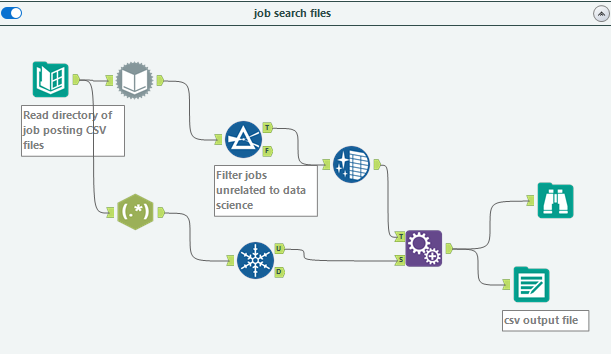

## Preprocessing

- Use Parts of Speech (POS) tagging on corpus of job descriptions to identify keywords and extraneous words such as "data", "experience", "business"

In [79]:
txt_data = nltk.data.load('data/job_postings_corpus.txt')

In [80]:
print(txt_data[0:100])

 milestone technologies hiring sr dev ops engineer based usa one clients urgent need looking someone


In [82]:
# Tokenize the article into sentences: sentences
words = nltk.word_tokenize(txt_data)

In [83]:
len(words)

285044

In [84]:
words[0:25]

['milestone',
 'technologies',
 'hiring',
 'sr',
 'dev',
 'ops',
 'engineer',
 'based',
 'usa',
 'one',
 'clients',
 'urgent',
 'need',
 'looking',
 'someone',
 'start',
 'asap',
 'data',
 'science',
 'engineer',
 'responsible',
 'building',
 'ai',
 'ml',
 'solutions']

### Part of Speech Tagging

In [85]:
def pos_tag_counts(words):
    """
    Creates dataframe of parts of speech (pos) value counts and then prints out value_counts
    """
    df = pd.DataFrame(pos_tag(words), columns=['word', 'tag'])
    print(df.value_counts())
    return df

#### First Pass

In [87]:
df_1 = pos_tag_counts(words)

word           tag
data           NNS    10180
experience     NN      3601
business       NN      2997
work           NN      1696
years          NNS     1692
                      ...  
relation       NN         1
firehouse      VBP        1
relatedwork    NN         1
relatedfield•  NN         1
0              CD         1
Length: 17149, dtype: int64


#### Second Pass

In [88]:
txt_data2 = nltk.data.load('data/job_postings_corpus_v2.txt')

In [89]:
words_2 = nltk.word_tokenize(txt_data2)

In [90]:
df_second = pos_tag_counts(words_2)

word        tag
management  NN     1636
science     NN     1517
team        NN     1475
skills      NNS    1435
solutions   NNS    1407
                   ... 
remaining   VBG       1
freight     VBD       1
frequency   NN        1
frequent    NN        1
0           CD        1
Length: 16557, dtype: int64


In [92]:
word_count_series = df_second.groupby(["word"])["tag"].count().sort_values(ascending=False)
word_count_df = pd.DataFrame(word_count_series)
word_count_df.head(50)

,tag
word,
engineer,1774
team,1639
management,1636
science,1571
skills,1491
solutions,1407
analytics,1331
development,1261
analysis,1113


#### Third Pass

In [93]:
txt_data3 = nltk.data.load('data/job_postings_corpus_v3.txt')

In [94]:
words_3 = nltk.word_tokenize(txt_data3)

In [95]:
df_3 = pos_tag_counts(words_3)

word          tag
science       NN     1520
engineer      NN     1338
analytics     NNS    1306
development   NN     1261
requirements  NNS    1108
                     ... 
refreshed     VBN       1
fortrends     NNS       1
fortune       NNS       1
reflects      VBZ       1
0             CD        1
Length: 16363, dtype: int64


In [101]:
word_count_series_3 = df_3.groupby(["word"])["tag"].count().sort_values(ascending=False)
word_count_df_3 = pd.DataFrame(word_count_series_3)
word_count_df_3.head(50)

,tag
word,
engineer,1774
science,1571
analytics,1331
development,1261
analysis,1113
requirements,1108
design,1082
support,1059
knowledge,1057


### Create Label Column

- Use **`Alteryx`** workflow to label job postings based on keywords in the job description
- Write output to CSV file

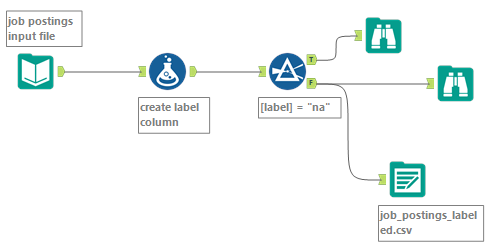

## Job Postings Data Set
- Read job_postings_labeled.csv which was created in preprocessing step into dataframe

In [193]:
job_postings_df = pd.read_csv('data/job_postings_labeled.csv')

In [194]:
job_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city             856 non-null    object
 1   job_title        856 non-null    object
 2   job_description  856 non-null    object
 3   label            856 non-null    object
dtypes: object(4)
memory usage: 26.9+ KB


In [195]:
job_postings_df.head()

,city,job_title,job_description,label
0,denver,Data Science Engineer,dev engineer one urgent need engineer ai ml id...,cloud_data
1,denver,Data Science Trainee,equal employer committed qualified trainee joi...,modeling
2,denver,Visualization Consultant (Data Science),market retail e commerce partner worlds weve...,modeling
3,denver,Data Science Engineer (100% Remote),include creation delivery advanced big environ...,analytics
4,denver,Data Science Visualization Specialist,actively join government advanced iterative ag...,cloud_data


In [196]:
job_postings_df['label'].value_counts()

cloud_data    454
modeling      371
analytics      28
programmer      3
Name: label, dtype: int64

> The **`programmer`** job descriptions will be removed from data set since there are only three samples classified as programmer

In [197]:
job_postings_df = job_postings_df.loc[job_postings_df.label!='programmer']

In [198]:
job_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 855
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city             853 non-null    object
 1   job_title        853 non-null    object
 2   job_description  853 non-null    object
 3   label            853 non-null    object
dtypes: object(4)
memory usage: 33.3+ KB


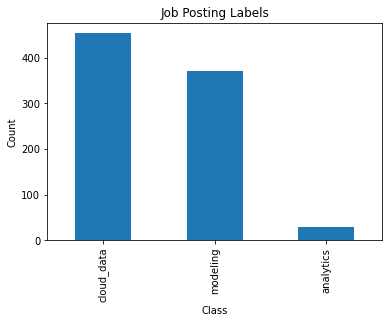

In [199]:
job_postings_df['label'].value_counts().plot(kind='bar')
plt.title("Job Posting Labels")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

In [200]:
job_postings_df['label'].value_counts()

cloud_data    454
modeling      371
analytics      28
Name: label, dtype: int64

### Encode labels

In [201]:
class_map = {label:idx for idx, label in enumerate(np.unique(job_postings_df['label']))}
class_map

{'analytics': 0, 'cloud_data': 1, 'modeling': 2}

In [202]:
job_postings_df['class_label'] = job_postings_df['label'].map(class_map)

In [203]:
job_postings_df.head()

,city,job_title,job_description,label,class_label
0,denver,Data Science Engineer,dev engineer one urgent need engineer ai ml id...,cloud_data,1
1,denver,Data Science Trainee,equal employer committed qualified trainee joi...,modeling,2
2,denver,Visualization Consultant (Data Science),market retail e commerce partner worlds weve...,modeling,2
3,denver,Data Science Engineer (100% Remote),include creation delivery advanced big environ...,analytics,0
4,denver,Data Science Visualization Specialist,actively join government advanced iterative ag...,cloud_data,1


### Split dataframe into Training and Test sets

In [204]:
dataset = job_postings_df[['job_description', 'class_label']]

In [205]:
dataset.head()

,job_description,class_label
0,dev engineer one urgent need engineer ai ml id...,1
1,equal employer committed qualified trainee joi...,2
2,market retail e commerce partner worlds weve...,2
3,include creation delivery advanced big environ...,0
4,actively join government advanced iterative ag...,1


In [206]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [208]:
X_train[:5]

array([['property domain remote candidate contractcorp corp welcome apply dot dot com input output internal validation property domain target unexpected back third party analyze integrate analytical problem documentation communication bachelor\x92s degree major equivalent'],
       ['optimize profit minimize turnover help make better complex market behavior reach accuracy yearly total pay remote bachelor graduate degree engineer ing equivalent problem machine critical attention detaila leader critical thinker contribute collection neededverify accurate effectively broader identify needed produce future may apply'],
       ['private group llc veteran owned firm northern virginia commercial federal agile provide competitive advantage like join tech that\x92s agile reality federal attitude ethic growth that\x92s tangible impact world culture life balance apart none provide contribute within collaborative difference challenge grow careerwe realize honor large operate centricity core embrac

In [209]:
y_train[:5]

array([2, 2, 1, 1, 1], dtype=int64)

### Word tokenization

In [210]:
train_data = [line[0] for line in X_train]

In [211]:
train_data[0:4]

['property domain remote candidate contractcorp corp welcome apply dot dot com input output internal validation property domain target unexpected back third party analyze integrate analytical problem documentation communication bachelor\x92s degree major equivalent',
 'optimize profit minimize turnover help make better complex market behavior reach accuracy yearly total pay remote bachelor graduate degree engineer ing equivalent problem machine critical attention detaila leader critical thinker contribute collection neededverify accurate effectively broader identify needed produce future may apply',
 'private group llc veteran owned firm northern virginia commercial federal agile provide competitive advantage like join tech that\x92s agile reality federal attitude ethic growth that\x92s tangible impact world culture life balance apart none provide contribute within collaborative difference challenge grow careerwe realize honor large operate centricity core embrace innovation creativity

In [212]:
count_vectorizer = CountVectorizer()

In [213]:
train_job_descriptions = count_vectorizer.fit_transform(train_data)

In [214]:
train_job_descriptions

<682x4418 sparse matrix of type '<class 'numpy.int64'>'
	with 70058 stored elements in Compressed Sparse Row format>

In [215]:
print(train_job_descriptions[0])

  (0, 3517)	2
  (0, 1298)	2
  (0, 3752)	1
  (0, 626)	1
  (0, 955)	1
  (0, 992)	1
  (0, 4325)	1
  (0, 304)	1
  (0, 1310)	2
  (0, 825)	1
  (0, 2278)	1
  (0, 3164)	1
  (0, 2307)	1
  (0, 4199)	1
  (0, 3914)	1
  (0, 4136)	1
  (0, 436)	1
  (0, 3995)	1
  (0, 3221)	1
  (0, 243)	1
  (0, 2282)	1
  (0, 241)	1
  (0, 3462)	1
  (0, 1289)	1
  (0, 853)	1
  (0, 435)	1
  (0, 1148)	1
  (0, 2631)	1
  (0, 1541)	1


## Naive Bayes Classifier

### Training Naive Bayes Classifier

In [216]:
mnb_classifier = MultinomialNB().fit(train_job_descriptions, y_train)

In [325]:
mnb_classifier.n_features_in_

4418

### Testing Naive Bayes Classifier

In [220]:
test_data = [line[0] for line in X_test]

In [221]:
test_data[0:4]

['big platform development engineer remote wide overview engineer evolve cloud platform validate normalize enrich rule healthcare provide big cloud engineer ing product program platform independent backend full development engineer advanced problem competency cloud enjoy paced engineer ing develop cloud platform around governance privacy thought leader partner development execution change feature drive value partner product drive agile delivery collaboration engineer ing within change manage optimize portfolio needed big java python proven track record large engineer ing public cloud s azure backend practical multi threaded development performance engineer ing development would helpful innovation better organization effectively multi mode convey clear unique need different accountable meet general office li remotejoin today better coordinated collaborative efficient healthcare covid vaccination remain committed part health well require covid vaccination prior employment may require per

In [222]:
test_job_descriptions = count_vectorizer.transform(test_data)

In [326]:
test_job_descriptions

<171x4418 sparse matrix of type '<class 'numpy.int64'>'
	with 15906 stored elements in Compressed Sparse Row format>

In [223]:
test_predictions = mnb_classifier.predict(test_job_descriptions)

### Classification Metrics

In [280]:
def create_formatted_confusion_matrix(cm_param):
    """
    Create formatted confusion matrix for confusion matrix parameter
    
    param: cm_param - confusion matrix
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm_param, cmap=plt.cm.Blues, alpha=0.3)

    for i in range(cm_param.shape[0]):
        for j in range(cm_param.shape[1]):
            ax.text(x=j, y=i, s=cm_param[i, j], va='center', ha='center')

    plt.title("Confusion Matrix", fontweight="bold", fontsize="12")
    plt.xlabel('predicted label\n\n'
              'analytics: 0, cloud_data: 1, modeling: 2', fontsize="11.5")
    plt.ylabel('true label', fontsize="11.5")

    plt.tight_layout()
    plt.show()

In [281]:
# Create confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=test_predictions)

In [282]:
cm

array([[ 0,  3,  1],
       [ 0, 86,  5],
       [ 0, 16, 60]], dtype=int64)

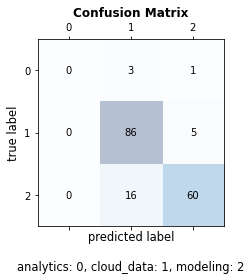

In [284]:
create_formatted_confusion_matrix(cm)

In [270]:
classification_report = classification_report(y_test, test_predictions, target_names=["analytics", "cloud_data", "modeling"], zero_division=0)

In [271]:
print(classification_report)

              precision    recall  f1-score   support

   analytics       0.00      0.00      0.00         4
  cloud_data       0.82      0.95      0.88        91
    modeling       0.91      0.79      0.85        76

    accuracy                           0.85       171
   macro avg       0.58      0.58      0.57       171
weighted avg       0.84      0.85      0.84       171



In [273]:
np.mean(y_test==test_predictions)

0.8538011695906432

## Random Forest Classifier

### Training Random Forest Classifier

In [319]:
rf_classifier = RandomForestClassifier(random_state=0, verbose=1)

In [320]:
rf_classifier.fit(train_job_descriptions, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(random_state=0, verbose=1)

In [324]:
rf_classifier.n_features_in_

4418

### Testing Random Forest Classifier

In [321]:
rf_test_predictions = rf_classifier.predict(test_job_descriptions)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Classification Metrics Random Forest

In [322]:
# Create confusion matrix
rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_test_predictions)

In [323]:
rf_cm

array([[ 2,  1,  1],
       [ 0, 90,  1],
       [ 0,  4, 72]], dtype=int64)

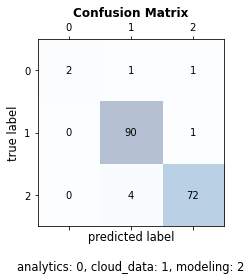

In [298]:
create_formatted_confusion_matrix(rf_cm)

In [299]:
rf_classification_report = classification_report(y_test, rf_test_predictions, target_names=["analytics", "cloud_data", "modeling"], zero_division=0)

In [300]:
print(rf_classification_report)

              precision    recall  f1-score   support

   analytics       1.00      0.50      0.67         4
  cloud_data       0.95      0.99      0.97        91
    modeling       0.97      0.95      0.96        76

    accuracy                           0.96       171
   macro avg       0.97      0.81      0.86       171
weighted avg       0.96      0.96      0.96       171



In [301]:
np.mean(y_test == rf_test_predictions)

0.9590643274853801

## References

Raschka, S.; Julian, D.; Hearty, J. Python: Deeper Insights into Machine Learning. Packt Publishing. Copyright 2016. 978-1-78712-857-6